# Extract single reads

Date: 23 Jan 2025

Using https://github.com/MichalRozenwald/epiCausality/blob/main/Extract_single_reads_%26_LR_2024Apr16.ipynb 
and https://github.com/MichalRozenwald/epiCausality/blob/main/gm12878_deepCTCF_updated_extract_reads.ipynb 

In [13]:
from dimelo import parse_bam, plot_enrichment_profile, plot_reads, load_processed, utils
import pysam
import platform

import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from matplotlib.axes import Axes
import numpy as np
import pandas as pd

print('System:',platform.system())
print('Release:',platform.release())
print('Version:',platform.version())
print('Processor:',platform.processor())

#  Pyton version
import sys
print(sys.version)
     

modkit found with expected version 0.2.4
System: Linux
Release: 6.8.0-51-generic
Version: #52~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Dec  9 15:00:52 UTC 2
Processor: x86_64
3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]


In [14]:
ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta') #'./test/output/chm13.draft_v1.1.fasta')
ref_genome_v1_1_file

PosixPath('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')

In [15]:
output_dir = Path("./dimelo_v2_output")
# Path('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package') # './test/output')

output_dir.mkdir(exist_ok=True)
output_dir

PosixPath('dimelo_v2_output')

In [16]:
! ls "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9/pod5_converted_basecall/5mCG/to_t2t_v1_1/"

align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
chr1_sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
chr1_sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam.bai
sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam.bai
summary_sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.tsv


In [17]:
unedited_bam_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"


In [37]:

# bam_path = unedited_bam_path
# threshold_mC=0.99

# t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
# window_size = None # 4000
# # window_size = 4000

# outname = f'cd55_window{window_size}'
# num_cores = 32

# cas9  = parse_bam.extract(
#     input_file=bam_path, # ctcf_bam_file_updated
#     output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_ws4000_thresh09', # _ws4000 'ctcf_demo_extract',
#     ref_genome=ref_genome_v1_1_file, # ref_genome_file,
#     output_directory=output_dir,
#     regions =t2t_v1_1_cd55_30bps, # [cd55_interest_target_regions], # ctcf_target_regions,ctcf_off_target_regions],
#     motifs=['CG,0'], # ['A,0','CG,0'],
#     thresh=threshold_mC,  # 0.75, # 190,
#     window_size=window_size, # None,
#     # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
#     # quiet = True,
#     # cleanup = False,
#     # log=True,
# )

# unedited_failed_extract_file_ws4000, uunedited_failed_extract_regions_ws4000 = cas9
# unedited_failed_extract_file_ws4000

# plot_reads.plot_reads(
#     unedited_failed_extract_file_ws4000, # cas9,
#     "chr1:206586162-206586192", # bed_region,
#     ['CG,0'],
#     window_size = window_size,
#     sort_by = ['shuffle','strand'], # ['strand'], # ['shuffle','strand'],
#     # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
#     s=1)
# plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
# # plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

 


No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.99 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.…

          |    0%

          | Transferring 2925 from reads.CG,0.txt into reads.combined_basemods.h5, new size 2925   0% | 00:00<…

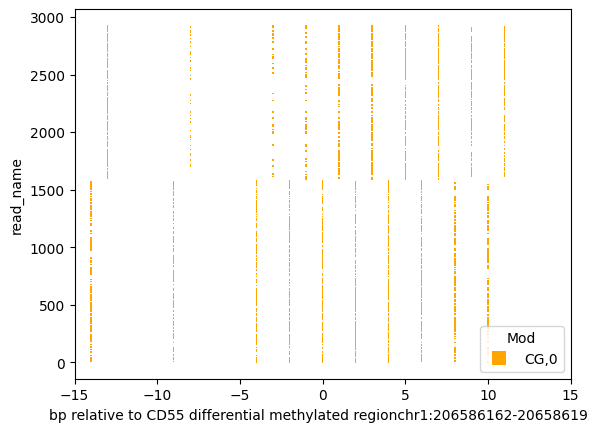

In [22]:
def extract_from_bam(bam_path, ref_genome_file, output_dir, 
                    window_size=None, threshold_mC=0.99, num_cores=32,
                    regions = 'chr1:206586162-206586192',
                    output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09',):
    """
    Processes a BAM file using the parse_bam.extract function and plots the extracted reads.

    Parameters:
        bam_path (str): Path to the input BAM file.
        ref_genome_file (str): Path to the reference genome file.
        output_dir (str): Directory to store output files.
        window_size (int, optional): Window size for extraction. Defaults to None.
        threshold_mC (float, optional): Threshold for methylation. Defaults to 0.99.
        num_cores (int, optional): Number of cores for processing. Defaults to 32.

    Returns:
        extract_file, extract_regions
    """

    extract_file, extract_regions  = parse_bam.extract(
        input_file=bam_path,
        output_name=output_name,
        ref_genome=ref_genome_file,
        output_directory=output_dir,
        regions=regions,
        motifs=['CG,0'],
        thresh=threshold_mC,
        window_size=window_size,
    )

    plot_reads.plot_reads(
        extract_file,
        t2t_v1_1_cd55_30bps,
        ['CG,0'],
        window_size=window_size,
        sort_by=['shuffle', 'strand'],
        s=1
    )

    plt.xlabel('bp relative to CD55 differential methylated region' + str(regions) )
    plt.show()

    return(extract_file, extract_regions )


# Example usage
bam_path = unedited_bam_path
threshold_mC=0.99

t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
window_size = None # 4000
# window_size = 4000

outname = f'cd55_window{window_size}'
num_cores = 32


extract_file, extract_regions = extract_from_bam(
    bam_path=unedited_bam_path,
    ref_genome_file=ref_genome_v1_1_file,
    output_dir=output_dir,
    window_size=window_size, # 4000,
    threshold_mC=threshold_mC, #0.99
    regions = 'chr1:206586162-206586192',
    output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09',
)


No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.75 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.…

          |    0%

          | Transferring 2925 from reads.CG,0.txt into reads.combined_basemods.h5, new size 2925   0% | 00:00<…

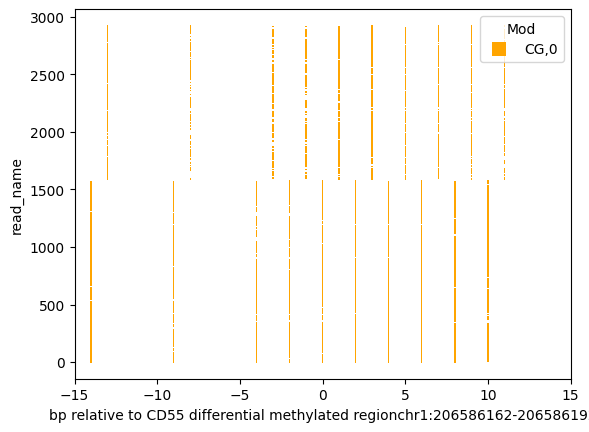

(PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09/reads.combined_basemods.h5'),
 PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09/regions.processed.bed'))

In [24]:

extract_from_bam(
    bam_path=unedited_bam_path,
    ref_genome_file=ref_genome_v1_1_file,
    output_dir=output_dir,
    window_size=window_size, # 4000,
    threshold_mC= 0.75, # threshold_mC, #0.99
    regions = 'chr1:206586162-206586192',
    output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09',
)

In [27]:
extract_file, extract_regions,

(PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09/reads.combined_basemods.h5'),
 PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09/regions.processed.bed'))

In [11]:
# ! python3 -m pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.9 MB/s eta 0:00:00


In [25]:
from Bio import SeqIO
from collections import defaultdict
import os

def process_extracted_reads(extract_file, extract_regions, ref_genome_file, padding=100):
    """
    Processes extracted reads to generate padded reads and a DataFrame.

    Parameters:
        extract_file (str): Path to the extracted reads file.
        extract_regions (str): Path to the extracted regions file.
        ref_genome_file (str): Path to the reference genome file.
        padding (int): Number of base pairs to pad around each region.

    Returns:
        padded_reads (dict): Dictionary with region identifiers as keys and padded read sequences as values.
        padded_reads_df (pd.DataFrame): DataFrame containing details of the padded reads.
    """
    # Load reference genome
    ref_genome = SeqIO.to_dict(SeqIO.parse(ref_genome_file, "fasta"))

    # Initialize containers
    padded_reads = {}
    padded_reads_data = []

    # Process each region
    with open(extract_regions, 'r') as regions_file:
        for line in regions_file:
            chrom, start, end, region_id = line.strip().split()
            start, end = int(start), int(end)

            # Apply padding
            padded_start = max(0, start - padding)
            padded_end = end + padding

            # Extract sequence
            if chrom in ref_genome:
                sequence = ref_genome[chrom].seq[padded_start:padded_end]
                padded_reads[region_id] = str(sequence)
                padded_reads_data.append({
                    'RegionID': region_id,
                    'Chromosome': chrom,
                    'Start': start,
                    'End': end,
                    'PaddedStart': padded_start,
                    'PaddedEnd': padded_end,
                    'Sequence': str(sequence)
                })
            else:
                print(f"Chromosome {chrom} not found in reference genome.")

    # Create DataFrame
    padded_reads_df = pd.DataFrame(padded_reads_data)

    return padded_reads, padded_reads_df

# Example usage
# extract_file = 'path/to/extract_file.txt'
# extract_regions = 'path/to/extract_regions.txt'
ref_genome_file = ref_genome_v1_1_file # 'path/to/ref_genome.fasta'

padded_reads, padded_reads_df = process_extracted_reads(extract_file, extract_regions, ref_genome_file)

ValueError: too many values to unpack (expected 4)

In [26]:
padded_reads, padded_reads_df

NameError: name 'padded_reads' is not defined